# Strip Templates and Manually Label Additional Comments
This notebook:
1. reads in the dataset of ~150k comments
2. merges the labels from the dataset of 500 comments manually labelled by CWP
3. labels ~50k additional comments based on identified templates
4. exports a random sample of 1000 unlabelled comments
5. imports the resulting file after these comments have been manually labelled
6. merges the new labels to the dataset
7. exports the resulting dataset to data/comments-labelled.csv

In [1]:
import pandas as pd

In [2]:
comments = pd.read_csv('data/comments.csv')
cwp = pd.read_csv('data/cwp-sample.csv')

In [3]:
# merge the 'Sentiment' labels from cwp dataset
df = pd.merge(
    comments, 
    cwp[['ID', 'Sentiment']], 
    how='left', 
    left_on='document_id', 
    right_on='ID'
)

In [4]:
# Remove comments with attachments
with_attachment_count = len(df[df['has_attachments']==True])
print("Removed " + str(with_attachment_count) + " comments with attachments.")
df = df[df['has_attachments']==False]

Removed 3814 comments with attachments.


In [5]:
empty_comments = ['Please Write Your Comment Here:', 'See attached']
for text in empty_comments:
    print('Removed %s comments consisting only of only "%s"' % (str(len(df[df['comment']==text])), text))
    df = df[df['comment']!=text]

Removed 1399 comments consisting only of only "Please Write Your Comment Here:"
Removed 55 comments consisting only of only "See attached"


In [7]:
import csv
with open('data/comment-templates.csv', 'r') as f:
    reader = csv.DictReader(f)
    templates = [row for row in reader]
templates[:2]
df['template'] = False
for template in templates:
    count = len(df[~df['template'] & df['comment'].str.contains(template['Key']) ] )
    print('Labelled %s comments as %s with string "%s"' % (str(count), template['Sentiment'], template['Key']))
    df.loc[~df['template'] & df['comment'].str.contains(template['Key']), ['Sentiment', 'template']] = [template['Sentiment'], True]


Labelled 1287 comments as Positive with string "Our national monuments and public lands and waters help define who we are as a nation by telling the story of our historical, cultural, and natural heritage."
Labelled 386 comments as Positive with string "These historic sites represent a crucial part of our American heritage - they protect Native American sacred ground, preserve areas of historic and scientific value, and drive local economies with opportunities for recreation and tourism."
Labelled 3707 comments as Positive with string "Protected public lands are an important part of what makes America great. I strongly urge you to oppose any efforts to eliminate or shrink our national monuments."
Labelled 1224 comments as Positive with string "As a mountain biker and a citizen co-owner of our country's public lands, I SUPPORT our existing national monuments. "
Labelled 2060 comments as Positive with string "Bears Ears National Monument is ecologically rich and culturally valuable. Resc

In [10]:
print('Drawing a random sample of 1000 from a population of %s unlabelled comments.' % str(len(df['Sentiment'].isnull())))
print('having first removed ' + str(len(df[df['Sentiment'] == 'Positive'])) + ' positive comments')
print('and having first removed ' + str(len(df[df['Sentiment'] == 'Negative'])) + ' negative comments')

sample = df[df['Sentiment'].isnull()].sample(n=1000)
#sample.to_csv('data/expanded_sample.csv')

Drawing a random sample of 1000 from a population of 146363 unlabelled comments.
having first removed 56190 positive comments
and having first removed 548 negative comments


(Manually labelled comments by reviewing in Excel and saved resulting file as expanded_sample-labelled.csv)

In [8]:
# bring in the results from my manual labelling
labels = pd.read_csv('data/expanded_sample-labelled.csv')
for sentiment in list(labels['Sentiment'].unique()):
    doc_ids = labels.loc[labels['Sentiment']==sentiment, 'document_id']
    df.loc[df['document_id'].isin(doc_ids)] = sentiment    
    print("Labelled %s %s" % (str(len(doc_ids)), sentiment))

Labelled 941 Positive
Labelled 41 Negative
Labelled 18 Neutral


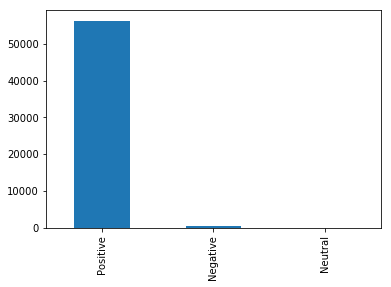

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
df['Sentiment'].value_counts().plot.bar()

In [12]:
# write results to file
df.to_csv('data/comments-labelled.csv')